# NASDAQ Stock History Analysis

#### This data science project tries to answer a few questions related to stock market history using a Kaggle dataset with stock prices up to 4/1/2020.

1) Is there a time of year of greatest variability in NASDAQ stock prices?
2) Is month to month variability in stock price significant?
3) What types of features can we engineer from stock market data?
4) Can stock performance on 4/1/2020 be predicted from historical data?



Dataset retrieved from: https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset/data


In [1]:
# libraries
import pandas as pd
import numpy as np
import csv
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


First, lets look at a sample dataset (AAPL)

In [2]:
AAPL = pd.read_csv('/Users/rossbrancati/Documents/ds_portfolio/Stock_price_project/Kaggle_dataset/stocks/AAPL.csv')
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400
...,...,...,...,...,...,...,...
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500


So it looks like each .csv file contains the date, several prices (open, high, low, close), and the total volume. 

To answer the first question, let's analyze the previous year's data for every ticker's closing price (from 4/1/19 to 4/1/20).

Define a function to take the data from each .csv file, retrieve the data between 4/1/19 and 4/1/20, and store the closing price as a row.

In [3]:
# Define function
def retrieve_stock_data(ticker_name):
    # Assign file_path
    file_path = '/Users/rossbrancati/Documents/ds_portfolio/Stock_price_project/Kaggle_dataset/stocks/' + ticker_name + '.csv'
    
    # Import data as array
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    
    # Find the index of April 1, 2019
    start_index = None
    for index, sublist in enumerate(data):
        if sublist[0] == '2019-04-01':
            start_index = index
            break
    
    # Segment data from 2019-04-01 to 2020-04-01
    data_array = np.array(data[start_index:len(data)])
    
    # Extract dates
    dates = [entry[0] for entry in data_array]
    
    # Extract closing price 
    close_price = [entry[4] for entry in data_array]
    
    return dates, close_price
    
    


In [4]:
# Create a directory to loop over individual stock files
stock_directory_path = '/Users/rossbrancati/Documents/ds_portfolio/Stock_price_project/Kaggle_dataset/stocks/'
stock_directory = os.chdir(stock_directory_path)

# Initialize a counter
counter = 0

# Create an empty dictionary to store results
stock_dict = {}

# Loop over files in directory and run function to extract closing prices
for file in os.listdir(stock_directory):
    
    # Assign ticker name and counter
    ticker_name = file[:-4]
    
    # Run function
    dates, closing_price = retrieve_stock_data(ticker_name)

    # Store dates - only need to add dates for first iteration
    if counter == 0:
        stock_dict['Date'] = dates
    
    # Store closing price
    stock_dict[ticker_name] = closing_price


Now we have a dictionary with several keys. The first key represents the date, and the next 5884 entries are the closing prices for the associated stock. 

Some of the stocks do not have data for an entire year, so let's remove them from the dictionary for this analysis.

In [5]:
# Make a copy of stock_dict
modified_stock_dict = stock_dict.copy()

# List to store keys to be removed
keys_to_remove = []

# Loop over keys and check the length of the associated lists
for key in modified_stock_dict:
    if len(modified_stock_dict[key]) != 254:
        keys_to_remove.append(key)
        
# Remove keys and associated data from the dictionary
for key in keys_to_remove:
    modified_stock_dict.pop(key, None)
    
# Remove other keys
modified_stock_dict.pop('PBTS', None)
    
# Stocks need to be converted from str to int
for key, data_list in modified_stock_dict.items():
    if key != 'Date':
        modified_stock_dict[key] = [float(value) for value in data_list]

Next, lets extract the top 100 performing stocks based on their closing price on April 1, 2020 from the modified_stock_dict dictionary

In [6]:
# Extract the last prices for each stock
last_prices = {stock: modified_stock_dict[stock][253] for stock in modified_stock_dict if stock != 'Date'}

# Sort stocks based on their last prices
top_stocks = sorted(last_prices.items(), key=lambda x: x[1], reverse=True)[:100]

# Dictionary to store top 100 performing stocks
top_100_stocks = {}

# Store data from top 100 stocks in new dictionary
for top_stock in top_stocks:
    top_100_stocks[top_stock[0]] = modified_stock_dict[top_stock[0]]


Lets plot the top performing stock closing prices over the year from 4/1/19 to 4/1/20.

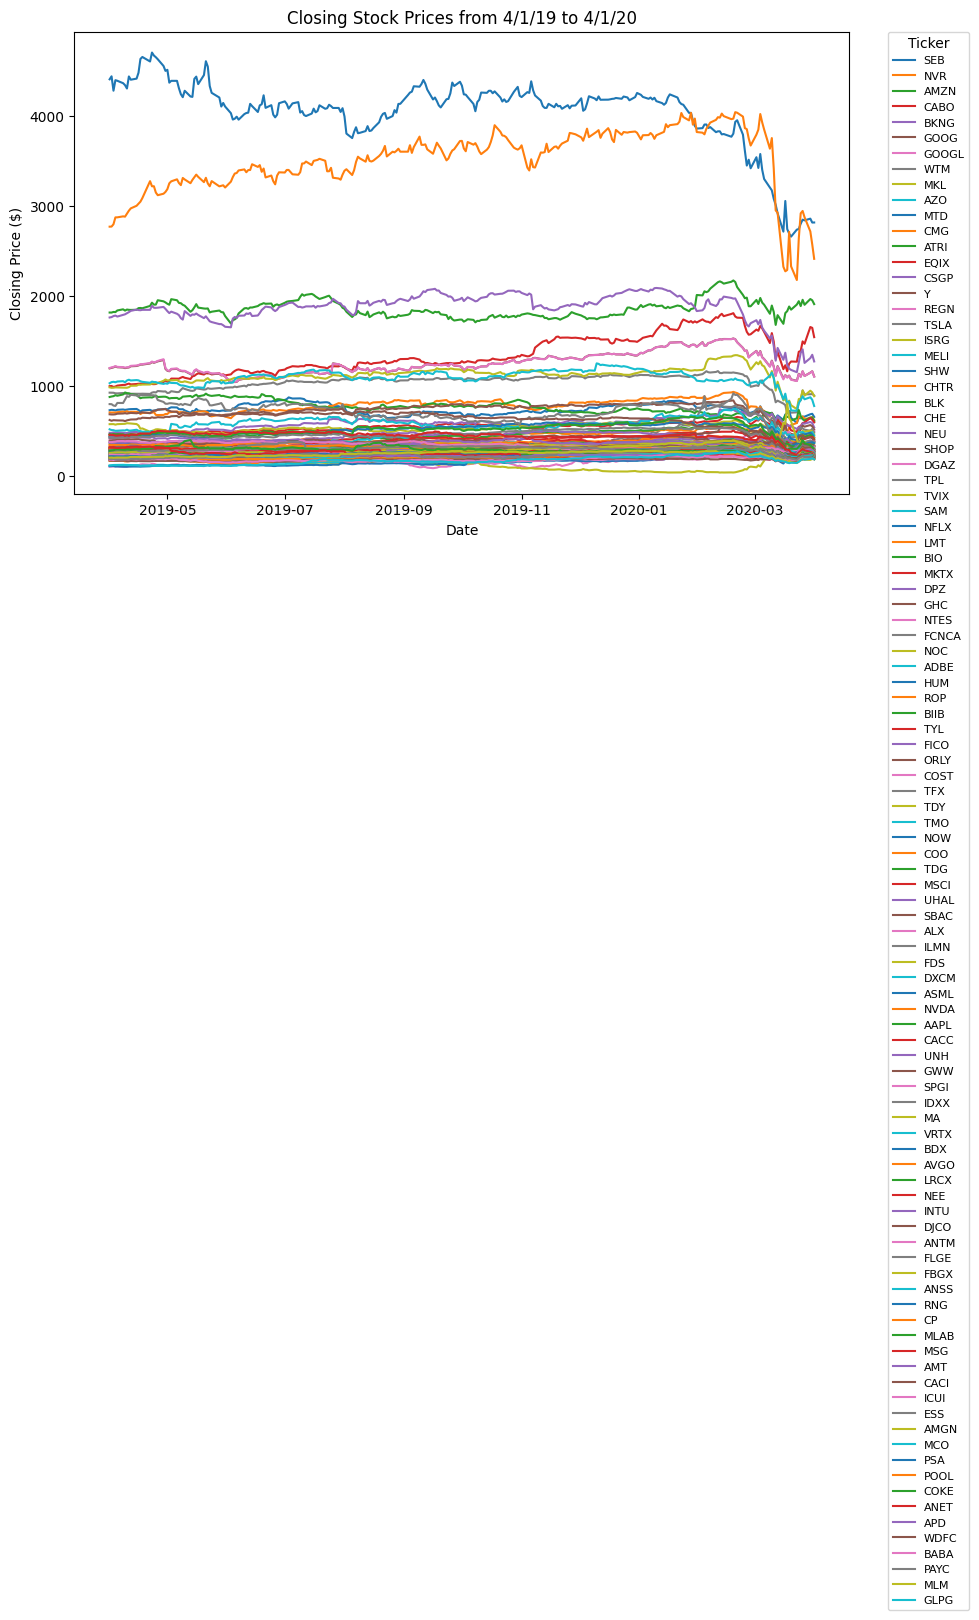

In [7]:
# X-axis label of dates
date_objects = [datetime.strptime(dt, '%Y-%m-%d') for dt in modified_stock_dict['Date']]

# Adjust plot size
plt.figure(figsize=(10, 6))

# Plot each row
for key, values in top_100_stocks.items():
    plt.plot(date_objects, values, label=key)

plt.title('Closing Stock Prices from 4/1/19 to 4/1/20')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8})

It looks like the stocks were relatively stable from 2019 to 2020 until March 2020 when COVID hit. Lets dive into some of the questions listed at the top of the notebook. 

### 1) Is there a time of the year when between stock prices have the highest variability?

To answer this question, we can use principal component analysis to determine the dates with the most variability. The eigenvectors can then be interpreted to determine the time of the year with greatest variability.

To start, lets go back to the modified_stock_dict and reformat it into an array where each row represents a stock and each column represents the closing price at a particular date.

In [8]:
# Create a copy of modified_stock_dict
modified_stock_dict_1 = modified_stock_dict.copy()

# Remove the date key from modified_stock_dict
modified_stock_dict_1.pop('Date', None)

# Transform dictionary into 5429x254 array
stock_array = np.array(list(modified_stock_dict_1.values()))

Next, lets perform PCA on this matrix and extract the explained variance, loadings (eigenvectors), and scores (transformed data). Luckily the PCA function scaled the data to have a mean of 0 and variance of 1, so we don't need to worry about that before hand

In [9]:
# Define number of components to keep
n_components = 254 

# Setup PCA and fit to data
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(stock_array)

# Access explained variance of each PC
explained_variance_ratio = pca.explained_variance_ratio_

# Access the loadings or eigenvectors
principal_components = pca.components_

# Access the PC scores or transformed data
pc_scores = pca_result

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Lets plot the explained variance ratio to see which PCs explain significant variance

Text(0, 0.5, 'Explained Variance')

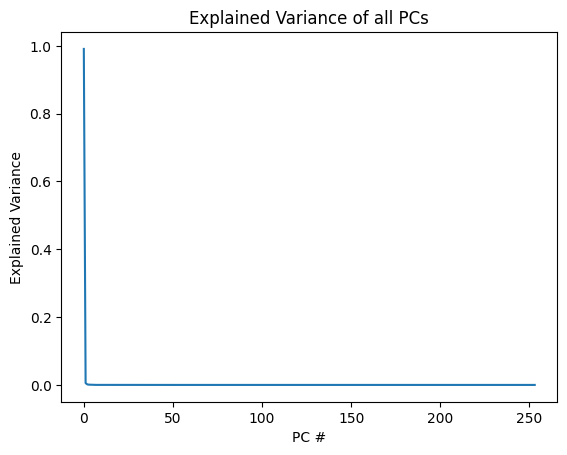

In [10]:
plt.plot(explained_variance_ratio)
plt.title('Explained Variance of all PCs')
plt.xlabel('PC #')
plt.ylabel('Explained Variance')

Not surprisingly, the majority of the variance is explained by the first PC. The other PCs might still be useful, so lets plot the explained variance for PCs 2-10.

Text(0, 0.5, 'Explained Variance')

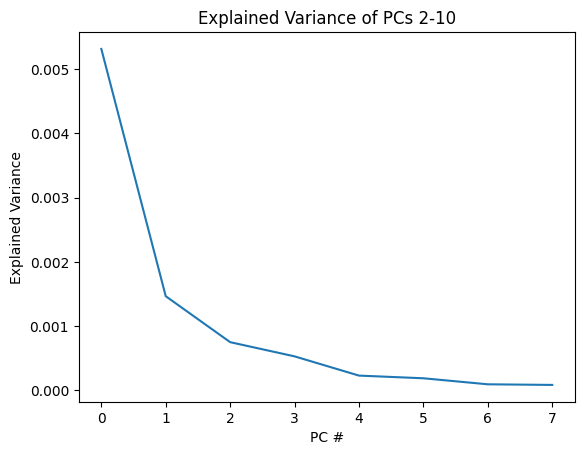

In [11]:
plt.plot(explained_variance_ratio[1:9])
plt.title('Explained Variance of PCs 2-10')
plt.xlabel('PC #')
plt.ylabel('Explained Variance')

It looks like the explained variance drops off significantly after PC 5. Lets look at the first 5 PCs. Its also useful to plot the mean of the principal component scores to see where the largest deviations from the mean occured.

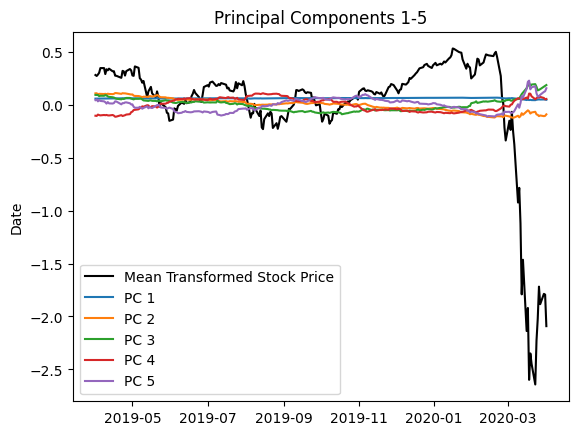

In [12]:
# Z-transform original stock data
row_mean = np.mean(stock_array, axis=1, keepdims=True)
row_std = np.std(stock_array, axis=1, keepdims=True)
# Replace stdevs exactly equal to 0 with very small number
row_std = np.where(row_std == 0, 1e-10, row_std)
z_trans_stock_array = (stock_array - row_mean) / row_std

# Calculate the average of all transformed stock prices
z_transformed_mean = np.mean(z_trans_stock_array, axis=0)

# Plot z_transformed_mean as a black line
plt.plot(date_objects, z_transformed_mean, color='black', label = 'Mean Transformed Stock Price')

# Plot PCs 1:5
for i in range(5):
    plt.plot(date_objects, principal_components[i,:], label='PC '+str(i+1))
    
plt.title('Principal Components 1-5')
plt.ylabel('Date')
plt.legend()

Lets also plot PC1 alone because it explained the majority of the variance

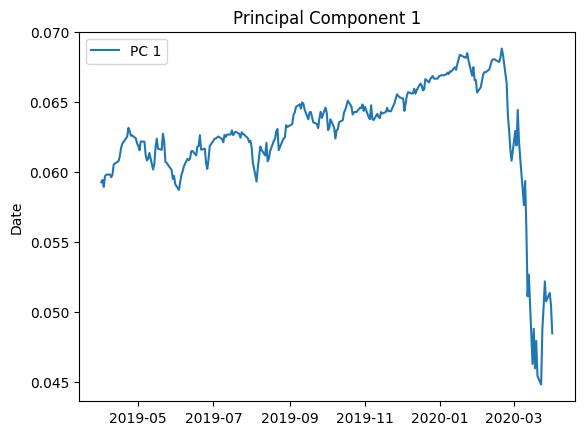

In [13]:
# Only plotting PC1
plt.plot(date_objects, principal_components[0,:], label='PC 1')
plt.title('Principal Component 1')
plt.ylabel('Date')
plt.legend()

### What can we gather from this analysis?

* Not surprisingly, the March had the greatest amount of variability from 4/1/19 to 4/1/20. This was when COVID first came to the US, causing a market shift. Since this is an anomoly, this analysis might have been more informative to more stable years without a major crisis that impacted stock price. The way this was interpreted was because the first PC is relatively stable until March, where it then drops off significantly as shown by the above figure.
* That being said, the other PCs can give us some good information about times of greatest variablity as well. Lets look as PC2. Looking at PC2 (two figures up - the orange line), we see that it is relatively stable up until November 2019. It then begins to deviate from the mean more and more as time goes on. This may have been due to COVID being present in other countries at the time. Analyzing other years could confirm or refute this hypothesis. 
* The 3rd, 4th, and 5th PCs show deviation from the mean at different months of the year, but also capture the variability around March. 

To conclude, it would likely be helpful for determining times of the year when stock variability is highest by running this analysis individually for multiple years. Its not surprising that major crises in the world impact stock price significantly as shown by COVID in this analysis.


Lets move onto feature engineering and a classification problem.


### 2) Can we predict if we should buy a stock using the previous month of data?

In this problem, we will analyze a single month of data, creating a label for the stock based on its change in closing price from the beginning to the end of the month (increase in price = positive, decrease in price = negative). We will then use data from the previous 6 months to see if we can predict a stock's movement for the current month. 

Since events like COVID cannot really be predicted, we will try to predict January's stock movement using features from the previous 6 months.

First, generate labels for each stock based on if the price went up or down in January. 

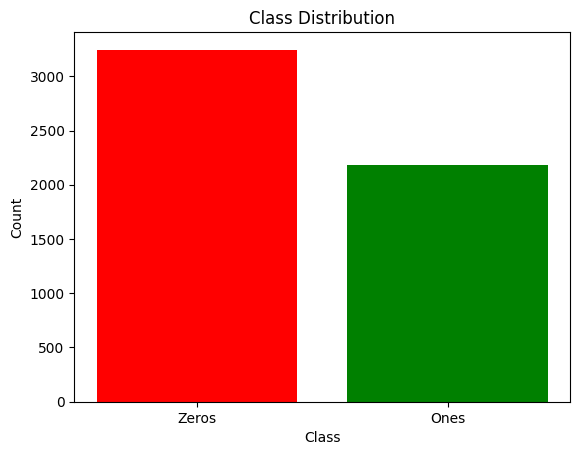

Percentage of Negative Labels:  59.77159697918586
Percentage of Positive Labels:  40.22840302081415


In [14]:
# To avoid overwriting previous data, create another copy of modified_stock_data
modified_stock_dict_2 = modified_stock_dict.copy()

# The first data for January is '2020-01-02' and the final date for January is '2020-01-31'
# Find the indices for these dates
jan_2_idx = modified_stock_dict_2['Date'].index('2020-01-02')
jan_31_idx = modified_stock_dict_2['Date'].index('2020-01-31')

# Determine if stock price went up (positive - 1) or down (negative - 0)
# Empty list to store labels
label_list = []
for key, values in modified_stock_dict_2.items():
    if key != 'Date':
        if values[jan_31_idx] - values[jan_2_idx] < 0:
            label_list.append(0)
        else: 
            label_list.append(1)
    
# Visualize class distribution
labels = ['Zeros', 'Ones']
counts = [label_list.count(0), label_list.count(1)]
plt.bar(labels, counts, color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

percent_zero = label_list.count(0)/len(label_list) * 100
percent_one = label_list.count(1)/len(label_list) * 100

print('Percentage of Negative Labels: ', percent_zero)
print('Percentage of Positive Labels: ', percent_one)

Overall there is a pretty even split between positive and negative classes (~60/40). Next lets extract the data from 6 months prior to January 2 to set up our features. 

In [15]:
# Extract data from July - December. The first data for July is '2019-07-01' and the final date for December is '2019-12-31'
# Find the indices for these dates
jul_1_idx = modified_stock_dict_2['Date'].index('2019-07-01')
dec_31_idx = modified_stock_dict_2['Date'].index('2019-12-31')

# Segment data between these two dates
jul_dec_stock_dict = {key: value[jul_1_idx:dec_31_idx+1] for key, value in modified_stock_dict_2.items()}

# Drop 'Date' key from dictionary, convert to array, and add labels based on performance
jul_dec_stock_dict.pop('Date', None)
stock_array = np.array(list(jul_dec_stock_dict.values()))
label_array = np.array(label_list)
stock_array_labs = np.insert(stock_array, 0, label_array, axis=1)

Lets explore the data a bit before diving into an ML models

Text(0.5, 1.0, 'Closing Stock Price - July to December')

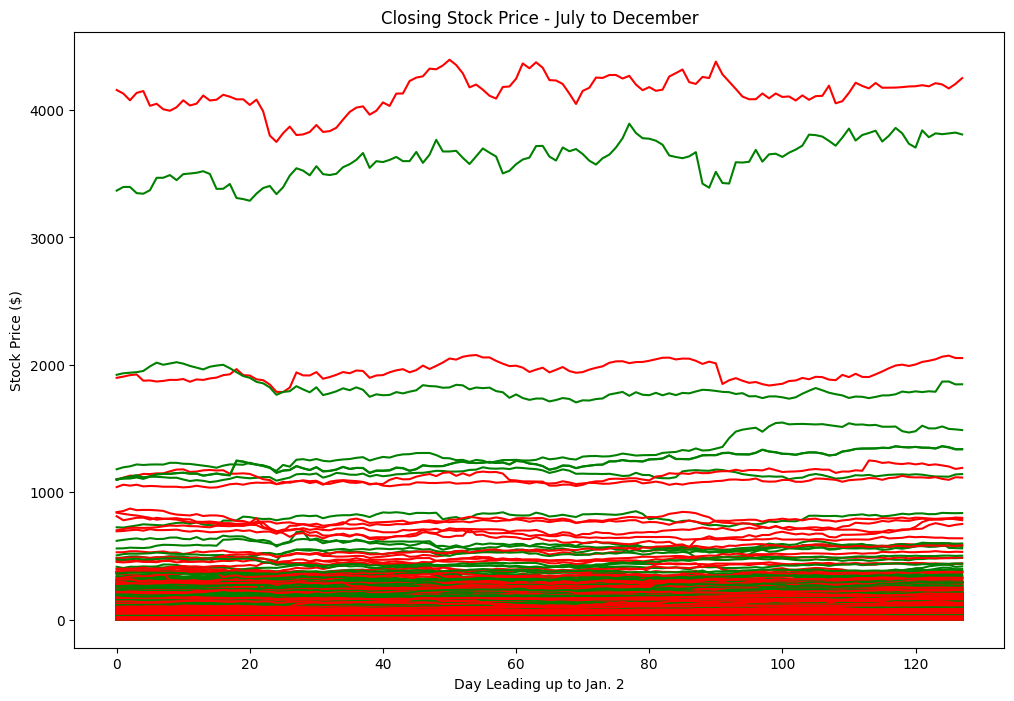

In [33]:
# Adjust plot size
plt.figure(figsize=(12, 8))

# Extract column 0 as labels and columns 1 to the end as data
labels = stock_array_labs[:, 0]
data = stock_array_labs[:, 1:]

# Plot each row as a line
for i in range(len(labels)):
    color = 'red' if labels[i] == 0 else 'green'
    plt.plot(data[i, :], label=f'Row {int(labels[i])}', color=color)
    
plt.xlabel('Day Leading up to Jan. 2')
plt.ylabel('Stock Price ($)')
plt.title('Closing Stock Price - July to December')

Now that we have an idea of what the data looks like and the class distributions, we can start engineering some features that hopefully capture patterns within the data. Another approach would be to feed time series data into a deep learning model. Lets start with creating some features and training/testing some simple classifiers.

Some features relevant to stock analysis include:
* Rate of return: percentage of change between consecutive closing prices
* Moving averages
* Variability (standard deviation) of the closing price
* Price rate change
* Regularity of the stock price (entropy)
* Magnitude of change from Jul-Dec

Lets create a function to calculate these features

In [441]:
# Define function
def get_features(stock_price, stock_price_unscaled):
    # Average rate of return
    ror_list = []
    for i in range(len(stock_price)):
        ror_list.append((stock_price[i]-stock_price[i-1])/stock_price[i-1])
    avg_ror = sum(ror_list)/len(ror_list)
    
    # 14 day moving average
    window = np.ones(14)/14
    moving_avg = np.convolve(stock_price, window, mode='valid')
    avg_moving_avg = sum(moving_avg)/len(moving_avg)
    
    # Variability (standard deviation)
    stddev = np.std(stock_price_unscaled)
    
    # Mean 
    #mean = np.mean(stock_price)
    
    # Price rate change over 32 day intervals (4 total intervals)
    prc_list = []
    for i in range(4):
        prc = (stock_price[((i+1)*32)-1] - stock_price[(i)*32]) / stock_price[(i)*32]
        prc_list.append(prc)
    
    # Entropy
    # Calculate the probabilities of each unique value in the array
    unique_values, counts = np.unique(stock_price, return_counts=True)
    probabilities = counts / len(stock_price)
    # Calculate entropy using the Shannon entropy formula
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    # Magnitude of change from Jul-Dec
    delta = stock_price[len(stock_price)-1] - stock_price[0]
    
    # Concatenate all features into a list
    feature_list = [avg_ror, avg_moving_avg, stddev, prc_list[0], prc_list[1], prc_list[2], prc_list[3], entropy, delta]
    
    return feature_list

In [442]:
# List to store features
all_feature_list = []

# Loop over rows in array, calculate features, and store
for i in range(data.shape[0]):
    
    # Assign stock_price
    stock_price = data[i, :]
    
    # Calculate mean and stddev of stock price
    mean_sp = np.mean(stock_price)
    sd_sp = np.std(stock_price)
    
    # If the standard deviation is exaclty 0, replace with very small number
    if sd_sp == 0.0:
        sd_sp = 1e-10
    
    # Scale stock price
    stock_price_scaled = (stock_price - mean_sp) / sd_sp
    
    # Replace any values of 0 with very small values
    stock_price_scaled = np.where(stock_price_scaled == 0, 1e-10, stock_price_scaled)
    
    # Calculate and store features
    feature_list = get_features(stock_price_scaled, stock_price)
    all_feature_list.append(feature_list)
    
# Convert to array
feature_array = np.array(all_feature_list)


Lets start the exploratory data analysis. First calculate correlation coefficients between variables

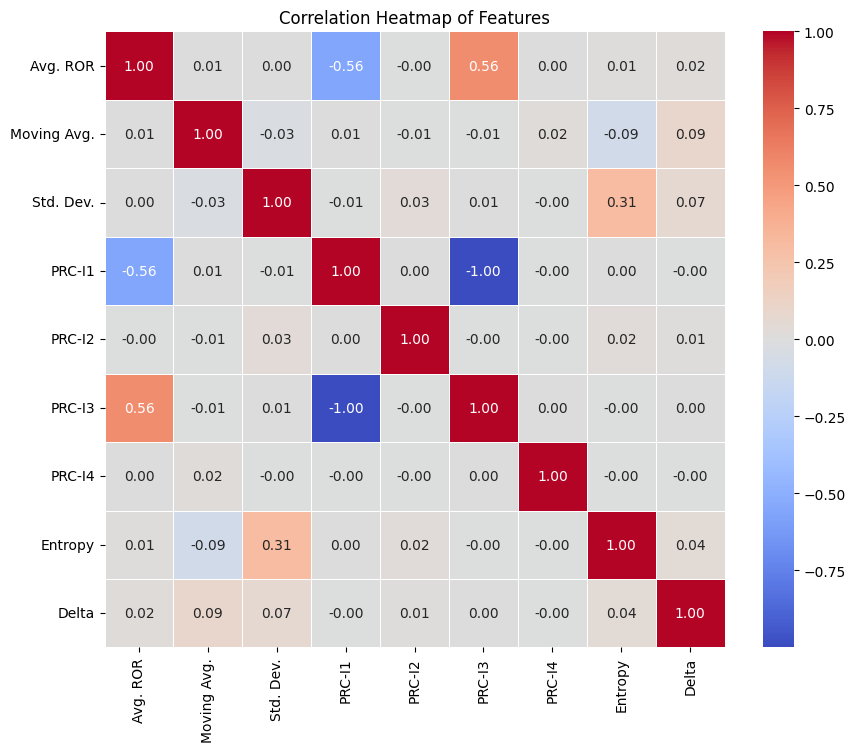

In [443]:
# Name variables
variable_names = ['Avg. ROR', 'Moving Avg.', 'Std. Dev.', 'PRC-I1', 'PRC-I2', 'PRC-I3', 'PRC-I4', 'Entropy', 'Delta']

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(feature_array, rowvar=False)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, xticklabels=variable_names, yticklabels=variable_names)
plt.title('Correlation Heatmap of Features')
plt.show()


Some of our features are perfectly correlated, some are moderately correlated, but a lot of them are not correlated. Leep all features for now and continue to explore the data. 

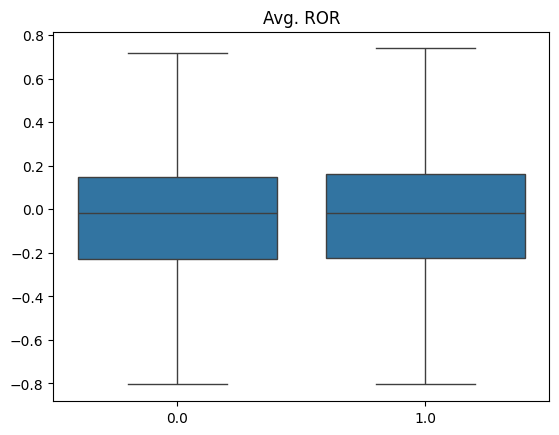

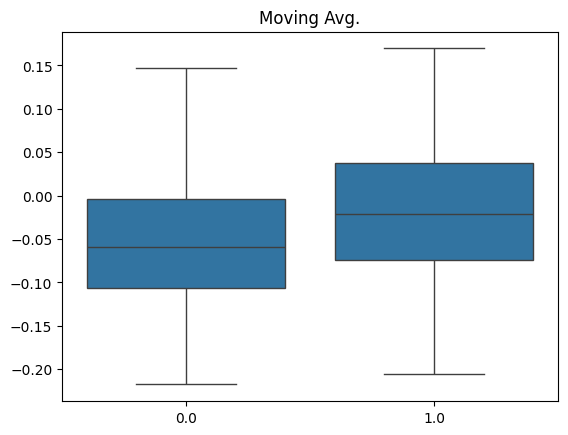

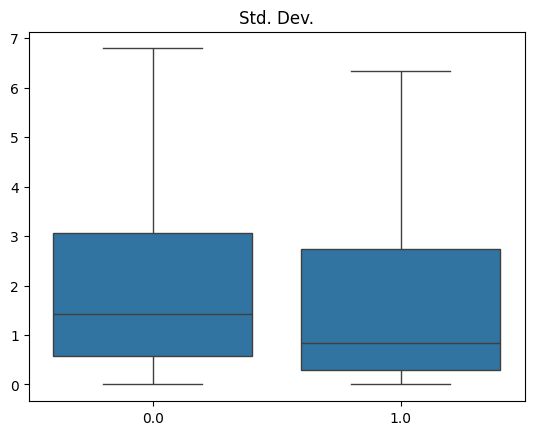

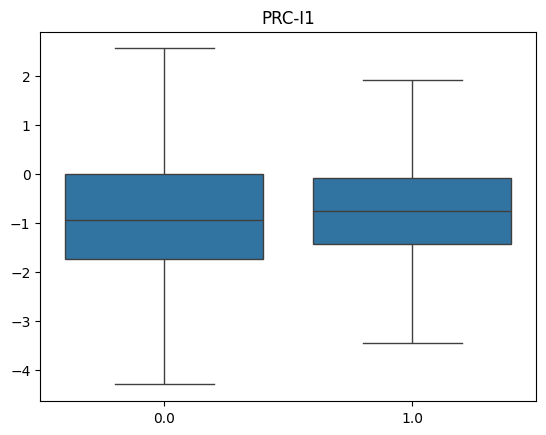

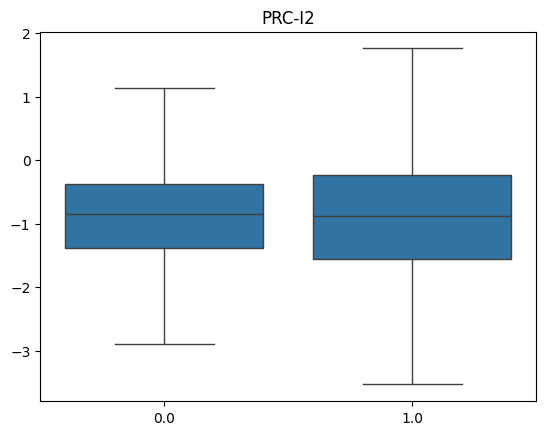

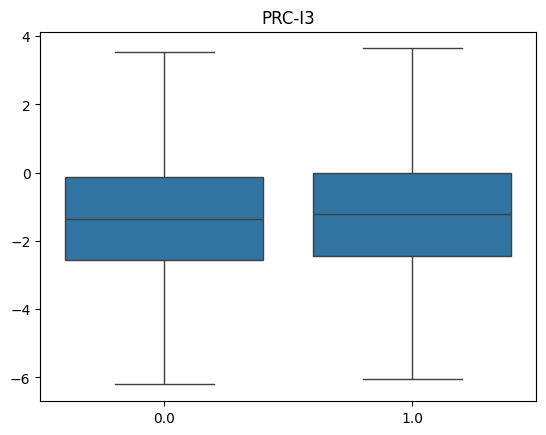

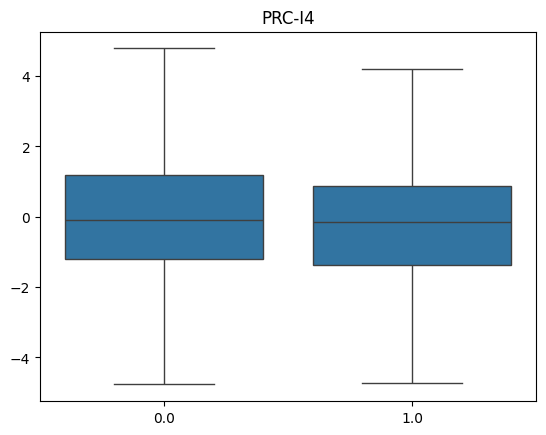

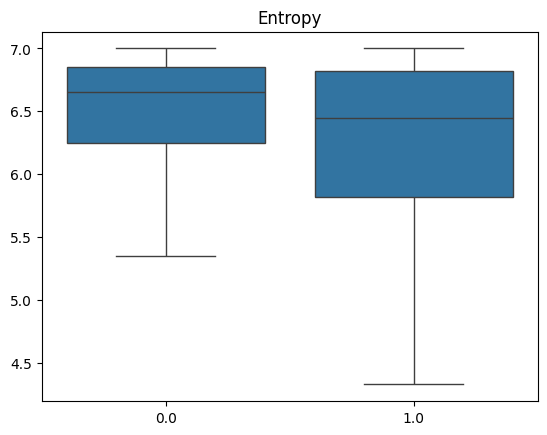

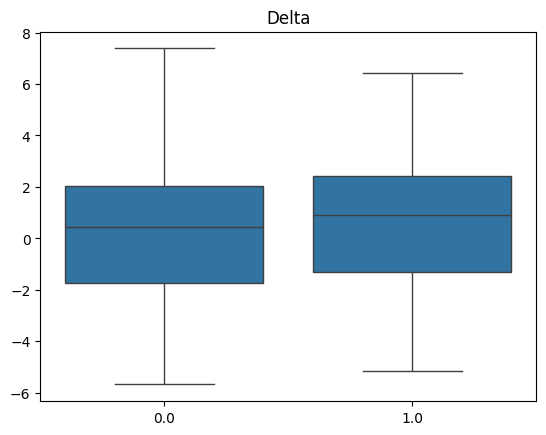

In [444]:
# Loop over features and create a box plot of data for each class
for i in range(9):
    sns.boxplot(x=labels, y=feature_array[:, i], showfliers=False)
    plt.title(variable_names[i])
    plt.show()
    

Now we can run some t-tests to see if there are any statistical differences between groups for these features.

In [446]:
# Loop over variables and run independent t-tests
for i in range(feature_array.shape[1]):
    
    # Assign data
    variable_values_class_0 = feature_array[labels == 0, i]
    variable_values_class_1 = feature_array[labels == 1, i]

    # Perform t-test
    t_statistic, p_value = ttest_ind(variable_values_class_0, variable_values_class_1)

    # Print results
    print('----------------')
    print(f"Variable: {variable_names[i]}")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    print('----------------')

----------------
Variable: Avg. ROR
T-statistic: 0.5652890732973915
P-value: 0.5719005271617088
----------------
----------------
Variable: Moving Avg.
T-statistic: -16.73258779075696
P-value: 2.554413563239498e-61
----------------
----------------
Variable: Std. Dev.
T-statistic: 0.48368824387265225
P-value: 0.6286266527848182
----------------
----------------
Variable: PRC-I1
T-statistic: -1.2195450082866734
P-value: 0.22269040221782088
----------------
----------------
Variable: PRC-I2
T-statistic: 0.19497135478933753
P-value: 0.845422671246351
----------------
----------------
Variable: PRC-I3
T-statistic: 1.22034763998768
P-value: 0.2223861402857215
----------------
----------------
Variable: PRC-I4
T-statistic: -0.3732536759139215
P-value: 0.7089742286191889
----------------
----------------
Variable: Entropy
T-statistic: 13.19729963652037
P-value: 3.6289675337840634e-39
----------------
----------------
Variable: Delta
T-statistic: -6.1060041289455365
P-value: 1.092492453065651e

So it looks like there are some statistical differences between the classes for some variables. First, we can try classifying the groups with a logistic regression classifier. 

Accuracy: 0.6178637200736649


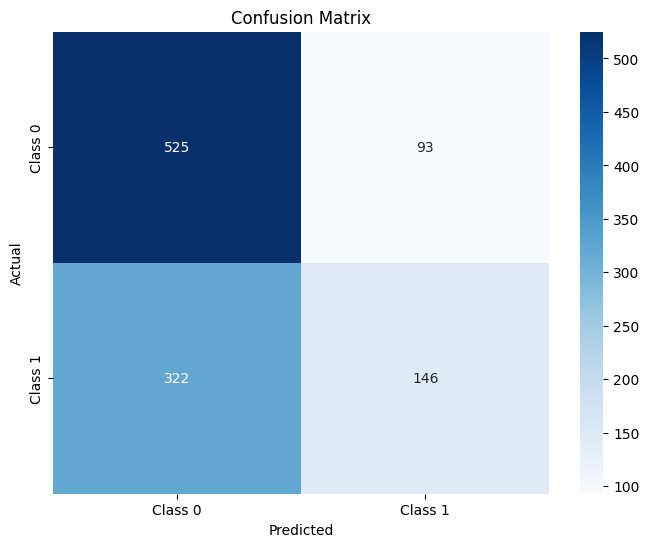

In [464]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_array, labels, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
# Accuracy
print("Accuracy:", accuracy)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



LR doesn't appear to work well with that input feature set. Lets try removing some of the features and re-running the model. Keep the 5 of the original 9 features based on statistical differences:
* Moving Avg. (column 2)
* PRC-I1 (column 4)
* PRC-I3 (column 6)
* Entropy (column 8)
* Delta (column 9)

Accuracy: 0.6187845303867403


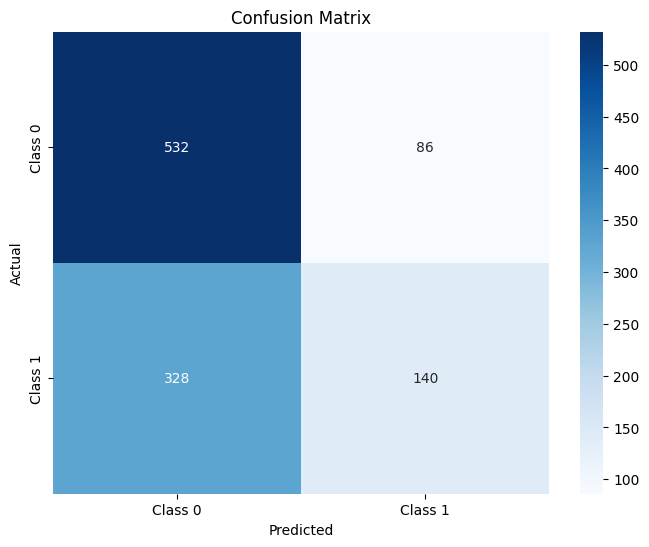

In [468]:
# Features to keep
new_features = [1, 3, 5, 7, 8]

# New feature array
feature_array_1 = feature_array[:, new_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_array_1, labels, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
# Accuracy
print("Accuracy:", accuracy)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


That didn't improve the accuracy by much. Lets try a support vector machine with the original dataset.

Accuracy: 0.6123388581952118


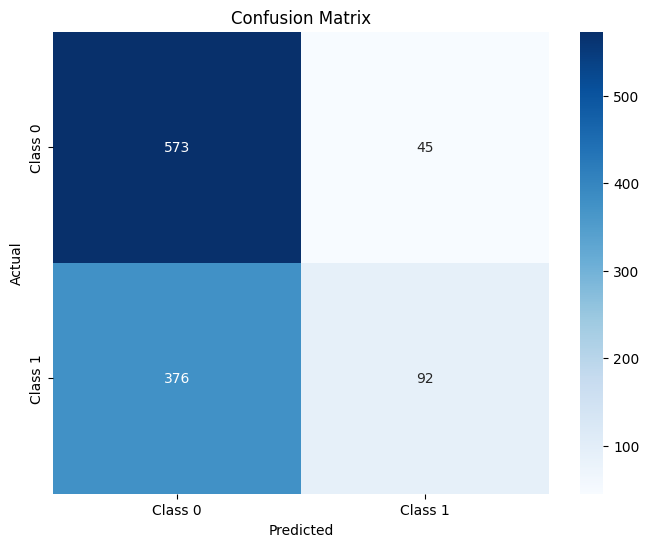

In [471]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_array, labels, test_size=0.2, random_state=42)

# Initialize the support vector machine
model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
# Accuracy
print("Accuracy:", accuracy)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM didn't perform great either. We can also try a random forest.

Accuracy: 0.6132596685082873


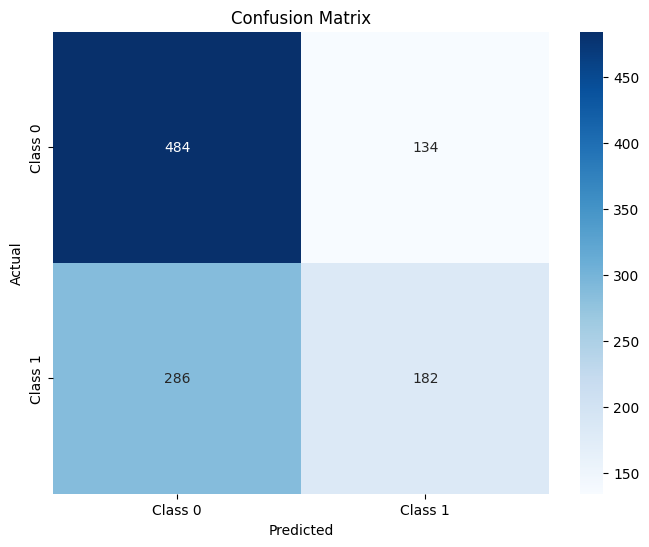

In [476]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_array, labels, test_size=0.2, random_state=42)

# Initialize the support vector machine
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
# Accuracy
print("Accuracy:", accuracy)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

So it looks like we can't really get an accuracy over ~60% with a simple classifier and these engineered features. We can also try a deep learning approach on the original 6 month data instead of extracting features.

### Deep learning approach with neural network (pytorch)

For our neural network, we'll use the 'data' (closing prices over 6 months). 'data' dimensions: (5429, 128)

In [37]:
data_new = data
data_new.shape

(5429, 128)

In [42]:
# Assign labels and data
labels = stock_array_labs[:, 0]
data = stock_array_labs[:, 1:]

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Step 2: Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Step 4: Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 5: Define the Neural Network architecture
class StockPredictionModel(nn.Module):
    def __init__(self):
        super(StockPredictionModel, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Step 6: Instantiate the model, loss function, and optimizer
model = StockPredictionModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train the model
epochs = 10
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

# Step 8: Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted_labels = (test_outputs > 0.5).float()

    accuracy = (predicted_labels == y_test_tensor.view(-1, 1)).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 56.91%


Conclusions from supervised ML approahes
* Simple classifiers demonstrated ~60% accuray in classifying if a stock would increase or decrease in January 2020 given engineered feeatures from the closing stock price in the previous 6 months
* A neural network performed worse than simple classifiers using raw closing stock price as training data
* These statistical and ML models confirm that stock price changes are very challenging to predict given closing price data. Some other approaches (different features, different ML models, larger datasets) might be better for prediction problems. 
* Regardless, even a 60% accuracy model is better than a random guess, so these models may be informative but should not be heavily relied on.